# Assignment: Decision Trees and Random Forests


## Business Understanding

In [130]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

random_state = 20
test_size = 0.2
max_depth = 2


## Data Understanding

Before we start to go through the data we can make a statement that this dataset does not contain any missing values and eventhough the documentation is poor, all features seem to be categorical and logical to some extent.

In [119]:
# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
data = phishing_websites.data.original
data.head()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


From the dataset we can see that it contains various features related to website being a legitimate or phishing site. The target variable is "result" which indicates whether the website is legitimate (1) or phishing (-1).

The variables and their possible values are as follows:
- having_ip_Address             (1, -1)
- url_Length                    (1, 0, -1)
- Shortining_service            (1, -1)
- having_at_Symbol              (1, -1)
- double_slash_redirecting      (1, -1)
- prefix_suffix                 (1, -1)
- having_sub_domain             (1, 0, -1)
- sslfinal_state                (1, 0, -1)
- domain_registration_length    (1, -1)
- favicon                       (1, -1)
- port                          (1, -1)
- https_token                   (1, -1)
- request_url                   (1, -1)
- url_of_anchor                 (1, 0, -1)
- links_in_tags                 (1, 0, -1)
- sfh                           (1, 0, -1)
- submitting_to_email           (1, -1)
- abnormal_url                  (1, -1)
- redirect                      (1, 0)
- on_mouseover                  (1, -1)
- rightclick                    (1, -1)
- popupwindow                   (1, -1)
- iframe                        (1, -1)
- age_of_domain                 (1, -1)
- dnsrecord                     (1, -1)
- web_traffic                   (1, 0, -1
- page_rank                     (1, -1)
- google_index                  (1, -1)
- links_pointing_to_page        (1, 0, -1)
- statistical_report            (1, -1)
- result                        (1, -1)

Documentation for the dataset is terrible, but in the original documentation it is said that for the target variable "result", 1 means legitimate and -1 means phishing. For the features we decided to assume that 1 means good and -1 means bad. Some features have also a neutral value of 0.

Lets see the distribution of the target variable "result" to understand how many phishing and legitimate websites are in the dataset.

In [120]:
legitimate_count = data[data['result'] == 1].shape[0]
phishing_count = data[data['result'] == -1].shape[0]
print(f'Legitimate websites: {legitimate_count}')
print(f'Phishing websites: {phishing_count}')

Legitimate websites: 6157
Phishing websites: 4898


To visualize the data distribution between classes, we can create histograms for each feature, layering the phishing and legitimate website data on top of each other.

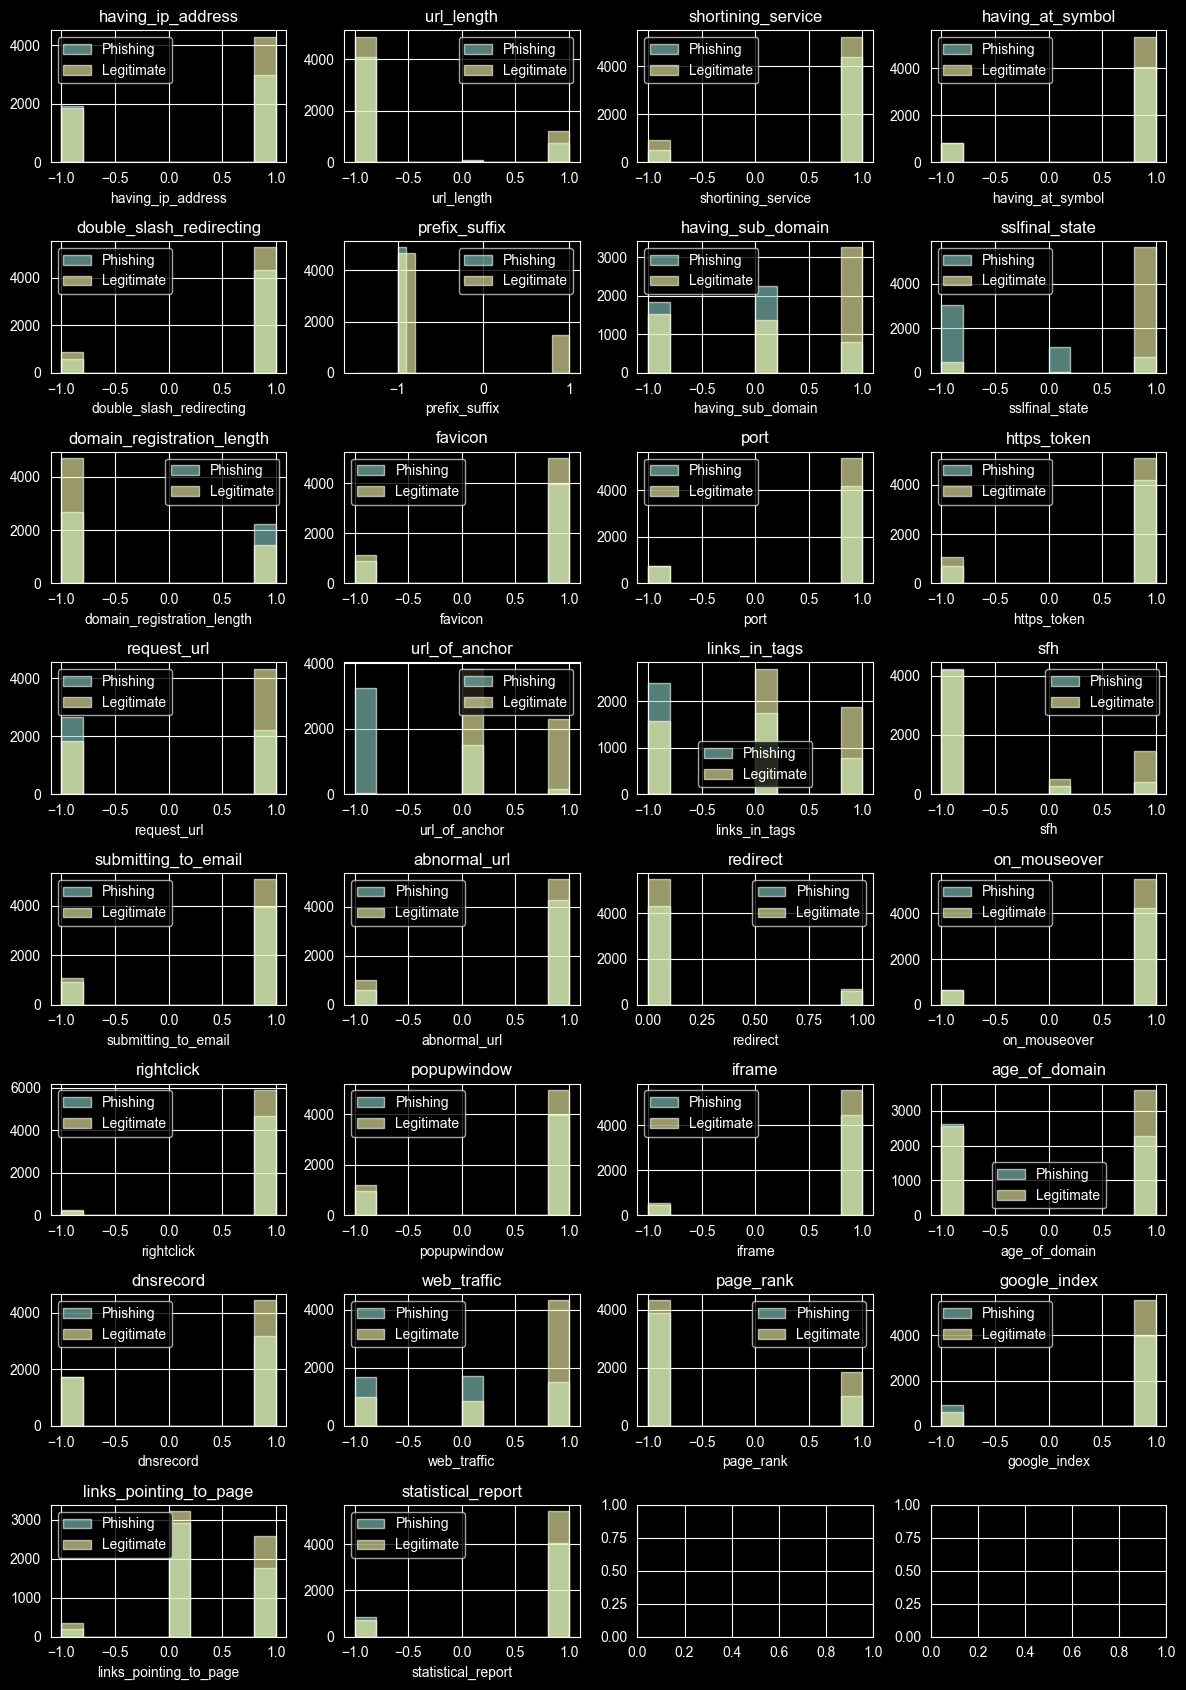

In [121]:
# Splitting the dataset to phishing and legitimate websites then for each feature we create a histogram where we layer the two classes on top of each other.
phishing_data = data[data['result'] == -1]
legitimate_date = data[data['result'] == 1]

phishing_data = phishing_data.drop(columns=['result'])
legitimate_date = legitimate_date.drop(columns=['result'])

# fig is for the whole figure, axes is for the individual subplots
fig, axes = plt.subplots(8, 4, figsize=(12, 17))
# axes.flatten() is used to convert the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# We know that both dataframes have the same columns, so we can use either for index and column names.
for i, column in enumerate(phishing_data.columns):
    ax = axes[i] # Temporary variable for the current subplot
    ax.hist(phishing_data[column], alpha=0.6, label='Phishing')
    ax.hist(legitimate_date[column], alpha=0.6, label='Legitimate')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

From the visualization we can see that features like "sslfinal_state", "request_url", "url_of_anchor", and "web_traffic" show more distinct differences between phishing and legitimate websites. These features could be more informative for the classification task.

## Data Preparation

Since we already made the statement that the dataset does not contain any missing values and all features are cleaned, we can proceed to split the dataset into training and test sets.

In [122]:
X = data.drop(columns=['result'])  # input features
y = data['result']  # target feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)  # extract test set

legitimate_train = y_train[y_train == 1].shape[0]
phishing_train = y_train[y_train == -1].shape[0]
legitimate_test = y_test[y_test == 1].shape[0]
phishing_test = y_test[y_test == -1].shape[0]

print(f'Training set - Legitimate: {legitimate_train}, Phishing: {phishing_train}')
print(f'Test set - Legitimate: {legitimate_test}, Phishing: {phishing_test}')

Training set - Legitimate: 4918, Phishing: 3926
Test set - Legitimate: 1239, Phishing: 972


## Modeling

For the modeling we will build a decision tree classifier with a maximum depth of 2. This depth is chosen to keep the model simple and interpretable, which is important for understanding how the model makes decisions.

In [123]:
model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",20
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

Now that the model is fitted we can visualize the decision tree to understand how it classifies websites as phishing or legitimate based on the features.

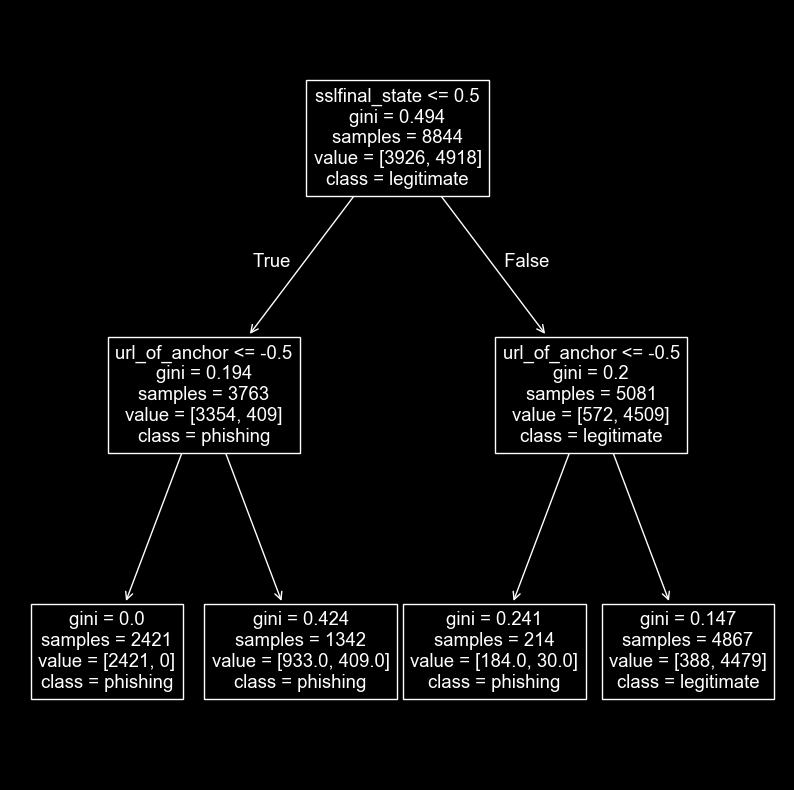

In [124]:
fig = plt.figure(figsize=(10, 10))
plot_tree(model, feature_names=X.keys(), class_names=['phishing', 'legitimate'])
plt.show()

In [125]:
# Calculating model accuracy on the test set
accuracy = model.score(X_test, y_test) * 100
print(f'Test set accuracy: {accuracy:.2f}%')

Test set accuracy: 90.55%


Like we predicted in the data understanding section, the model uses features like "sslfinal_state" and "url_of_anchor" to make its decisions. The tree structure shows how the model splits the data based on feature values to classify websites. To go over the models decision making logic more in detail:
- The root node looks at the "sslfinal_state" feature. If the value is less than or equal to 0.5, it indicates that the site is likely a phishing site.
- - Next it checks the "url_of_anchor" feature. If this value is less than or equal to -0.5, it classifies the site as phishing site with high confidence. If the value is greater than -0.5, it still classifies it as phishing but with lower confidence.
- To go back to the root node, if the "sslfinal_state" value is greater than 0.5, it indicates that the site is likely legitimate and moves over to the right child node.
- - Here it again checks the "url_of_anchor" feature. If this value is less than or equal to -0.5, it classifies the site as a phishing site with fair confidence. If the value is greater than -0.5, it classifies the site as legitimate with higher, but not 100% confidence.

Now we want to create random forest model and compare its performance to the decision tree model.

In [136]:
forest_model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=0.7, max_features=0.75, random_state=random_state,
                               oob_score=True)

forest_model.fit(X_train, y_train)

forest_accuracy = forest_model.score(X_test, y_test) * 100
print(f'Test set accuracy: {forest_accuracy:.2f}%')

Test set accuracy: 97.01%


## Evaluation

## Deployment